In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import math, random
from sklearn.metrics import mean_squared_error, zero_one_loss
from sklearn.model_selection import train_test_split

In [37]:
class NeuralNet():
    def __init__(self, inputs, no_nodes1, no_nodes2, eta, epochs):
        self.no_nodes_first_layer = no_nodes1
        self.no_nodes_second_layer = no_nodes2  
        self.no_input_nodes = inputs
        self.eta = eta
        self.epochs = epochs
        self.shape_y = 0
        self.number_of_layers = 2
        
        self.train_zero_losses = []
        self.train_ms_errors = []
        self.test_zero_losses = []
        self.test_ms_errors = []
        
        self.trained_weights = []
        
    def phi_function(self, x):
        return (2 / (1 + np.exp(-x))) - 1
    
    def phi_prime(self, x):
        return (1 + x)*(1 - x) / 2
    
    def init_weights(self, no_inputs, no_neurons):
        #np.random.seed(42)
        return np.random.normal(0, 1, size=(no_inputs + 1, no_neurons))
    
    def examine(self, x):
        w = self.trained_weights[0]
        v = self.trained_weights[1]
        hout,_ = self.forward_pass(v, w, x) 
        return hout[:,:3]
    
    def forward_pass(self, v, w, x):
        bias = np.ones([1, len(x)])
        x = np.column_stack([x, bias.T])
        hin = np.dot(x, w)
        hout = self.phi_function(hin)
        hout = np.column_stack([hout, bias.T])
        
        oin = np.dot(hout, v)
        oout = self.phi_function(oin)
        
        return hout, oout
    
    def backprop(self, v, t, oout, hout):
        t = t.reshape(t.shape[0],self.shape_y)        
        delta_o = np.multiply((oout - t), self.phi_prime(oout))  
        delta_h = np.dot(delta_o, v.T) * self.phi_prime(hout)
        delta_h = delta_h[:, :self.no_nodes_first_layer]
        return delta_h, delta_o
    
    def weight_update(self, x, hout, v, w, dv, dw, delta_h, delta_o):
        alpha = 0.9
        
        bias = np.ones(len(x))
        x = np.column_stack([x, bias.T])
      
        dw = (dw * alpha) - np.array(np.dot(x.T, delta_h)) * (1-alpha)
        dv = (dv * alpha) - np.array(np.dot(hout.T, delta_o)) * (1-alpha)
        
        w = w + dw * self.eta
        v = v + dv * self.eta 
        return (w, v, dw, dv)
      
    def test_accuracy(self, predictions, targets):
        # mean squared error
        mse = mean_squared_error(targets, predictions)

        incorrect = 0
        # accuracy
        for i in range(len(predictions)):
                if predictions[i] >= 0:
                    pred = 1
                else:
                    pred = -1
                if(targets[i] != pred):
                    incorrect += 1
        zero_one = incorrect/len(targets)
        
        return mse, zero_one
        
    def batch_learn(self, x_train, y_train, x_test, y_test, xx, yy, plot):
        self.shape_y = int(y_train.size/len(y_train))
        w = self.init_weights(self.no_input_nodes, self.no_nodes_first_layer)
        v = self.init_weights(self.no_nodes_first_layer, self.no_nodes_second_layer)
        dw = 0
        dv = 0
        
        for i in range(self.epochs):
            hout, oout = self.forward_pass(v, w, x_train)
            delta_h, delta_o = self.backprop(v, y_train, oout, hout)

            w, v, dw, dv = self.weight_update(x_train, hout, v, w, dv, dw, delta_h, delta_o)
            
            _, train_predictions = self.forward_pass(v, w, x_train)
            train_mse, train_zero_one = self.test_accuracy(train_predictions, y_train)
            
            _, test_predictions = self.forward_pass(v, w, x_test)
            test_mse, test_zero_one = self.test_accuracy(test_predictions, y_test)
            
            self.train_zero_losses.append(train_zero_one)
            self.train_ms_errors.append(train_mse)
            self.test_zero_losses.append(test_zero_one)
            self.test_ms_errors.append(test_mse)
            
            if (i%9==0) and plot:
                self.plot_gaussian(train_predictions, xx, yy)
        self.trained_weights.append(w)
        self.trained_weights.append(v)
            
            
    def plot_errors(self):
        f,axarr = plt.subplots(2,sharex=True)
        axarr[0].plot(range(self.epochs),self.train_zero_losses, '-',label="train")
        axarr[0].plot(range(self.epochs),self.test_zero_losses, '-',label="test")
        axarr[0].set_title('Ratio of misclassifications')
        
        axarr[1].plot(range(self.epochs),self.train_ms_errors, '-',label="train")
        axarr[1].plot(range(self.epochs),self.test_ms_errors, '-',label="test")
        axarr[1].set_title('Mean squared error')
        
        plt.grid()
        plt.legend()
        plt.show()
        
    def plot_gaussian(self, prediction, xx, yy):
        #print(self.getMseTrainLast())
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        
        prediction = np.reshape(prediction, (21,21))

        # Plot the surface.
        surf = ax.plot_surface(xx, yy, prediction, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)
        # Customize the z axis.
        ax.set_zlim(-0.5, 0.5)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

        plt.show()
        
    def final_errors(self):
        print("Final MSE:", self.train_ms_errors[-1])
        #print("Final Zero-One Loss:", self.train_zero_losses[-1])
        

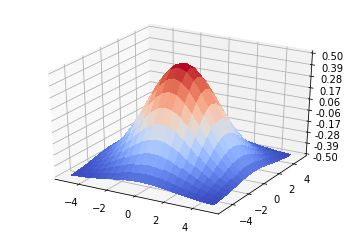

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')

x = np.arange(-5, 5.5, 0.5)
y = np.arange(-5, 5.5, 0.5)
xx, yy = np.meshgrid(x, y)
z = np.exp(-xx*xx*0.1) * np.exp(-yy*yy*0.1) - 0.5


# Plot the surface.
surf = ax.plot_surface(xx, yy, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.5, 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

targets = np.reshape(z, (21*21))
patterns = np.stack((np.reshape(xx, (21*21)), np.reshape(yy, (21*21))))

In [4]:
# Split data
def split_data(patterns, targets, frac):
    permute = list(range(len(targets)))
    random.shuffle(permute)

    patterns_perm = patterns.copy()[:, permute]
    targets_perm = targets.copy()[permute]
    
    return patterns_perm[:, round(frac*len(targets)):], targets_perm[round(frac*len(targets)):]


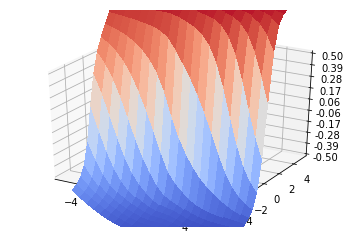

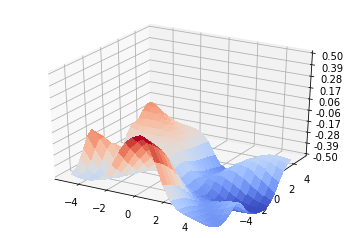

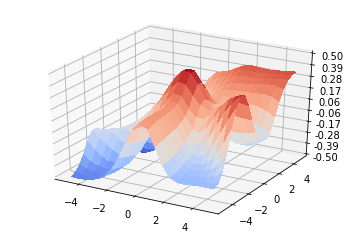

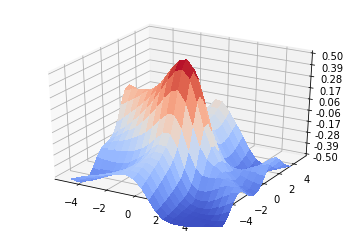

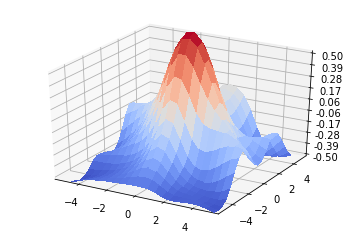

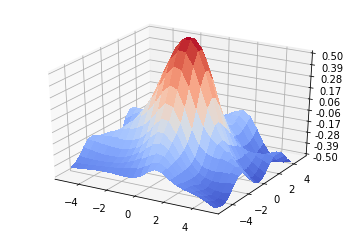

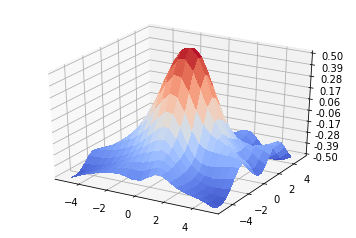

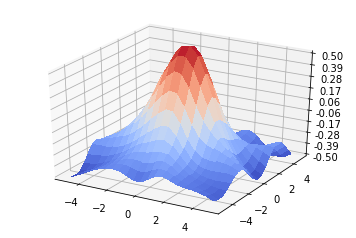

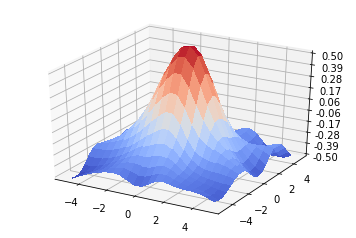

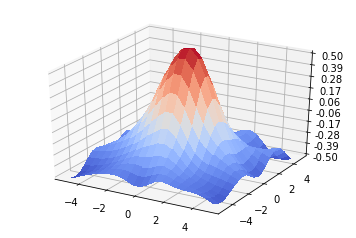

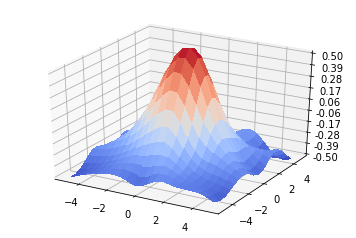

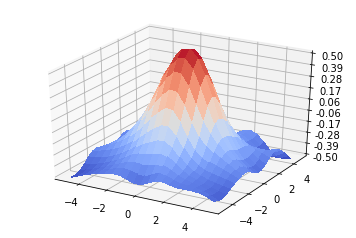

Final MSE: 0.002540038898758634


In [5]:
input_nodes = 2
nodes_hidden_layer = 25
nodes_output_layer = 1
eta = 0.01
epochs = 100

n = NeuralNet(input_nodes, nodes_hidden_layer, nodes_output_layer, eta, epochs)
n.batch_learn(patterns.T, targets, [], [], xx, yy, True)
n.final_errors()

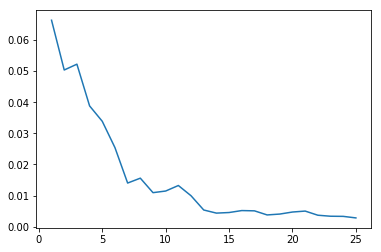

In [6]:
# Vary the number of nodes and check 1-25
input_nodes = 2
nodes_output_layer = 1
eta = 0.01
epochs = 70

mse = []
for nodes in range(1, 26):
    sum = 0
    for i in range(10):
        n = NeuralNet(input_nodes, nodes, nodes_output_layer, eta, epochs)
        n.batch_learn(patterns.T,targets,[],[],xx,yy, False)
        sum += n.train_ms_errors[-1]
    mse.append(sum/10)
plt.plot(range(1,26),mse)
plt.show()

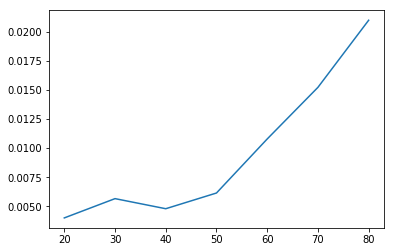

In [15]:
# Vary the training set from 80%-20%
input_nodes = 2
nodes_output_layer = 1
nodes_hidden_layer = 25
eta = 0.01
epochs = 70

mse = []
fractions = []
for frac in range(80, 10, -10):
    sum = 0
    patterns_train, targets_train = split_data(patterns, targets, frac/100)
    for i in range(10):
        n = NeuralNet(input_nodes, nodes_hidden_layer, nodes_output_layer, eta, epochs)
        n.batch_learn(patterns_train.T,targets_train,patterns.T,targets,xx,yy, False)
        sum += n.test_ms_errors[-1]
    mse.append(sum/10)
    fractions.append(frac)
plt.plot(fractions,mse)
plt.show()

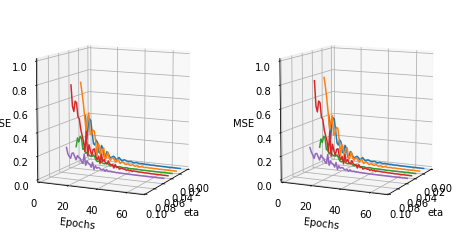

In [59]:
#Plot
fig = plt.figure(figsize=plt.figaspect(0.5))
trainAx = fig.add_subplot(1, 2, 1, projection='3d')
testAx = fig.add_subplot(1, 2, 2, projection='3d')



input_nodes = 2
nodes_output_layer = 1
nodes_hidden_layer = 25
eta = 0.01
epochs = 70

train_mse = []
test_mse = []
etas=[0.01, 0.02, 0.03, 0.04, 0.05]
patterns_train, targets_train = split_data(patterns, targets, 0.2)
for e in etas:
    train_sum = 0
    test_sum = 0
    n = NeuralNet(input_nodes, nodes_hidden_layer, nodes_output_layer, e, epochs)
    n.batch_learn(patterns_train.T,targets_train,patterns.T,targets,xx,yy, False)
    #train_sum += n.train_ms_errors[-1]
    #test_sum += n.test_ms_errors[-1]
    #train_mse.append(train_sum/10)
    #test_mse.append(test_sum/10)
    
    trainAx.plot(range(epochs), n.train_ms_errors, zs=e, zdir='x')
    testAx.plot(range(epochs), n.test_ms_errors, zs=e, zdir='x')

trainAx.set_xlabel('eta')
trainAx.set_ylabel('Epochs')
trainAx.set_zlabel('MSE')
trainAx.set_xlim(0, 0.1)
trainAx.set_ylim(0, 70)
trainAx.set_zlim(0, 1)
trainAx.view_init(elev=10., azim=25)


testAx.set_xlabel('eta')
testAx.set_ylabel('Epochs')
testAx.set_zlabel('MSE')
testAx.set_xlim(0, 0.1)
testAx.set_ylim(0, 70)
testAx.set_zlim(0, 1)
testAx.view_init(elev=10., azim=25)
plt.show()